In [18]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from custom_trading_env import TradingEnv
import DQNTradingAgent.dqn_agent as dqn_agent

device = torch.device('cpu')
dqn_agent.set_device(device)

from tqdm import tqdm, tnrange

In [19]:
n_action_intervals = 5

sample_len   = 480
obs_data_len = 192
step_len     = 1
fee          = 0.0005
sell_at_end  = False

hyperparam_path = "./saves/1/hyperparams.pth"
statedict_path  = "./saves/1/TradingGym_Rainbow_3000.pth"

In [20]:
df = pd.read_hdf('dataset/binance_data_train.h5', 'STW')
df.fillna(method='ffill', inplace=True)

In [21]:
env = TradingEnv(custom_args=None, env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                     df=df, fee=fee, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c',
                     sell_at_end=sell_at_end,
                     feature_names=['o', 'h','l','c','v',
                                    'num_trades', 'taker_base_vol'])

[2019-08-23 11:45:45,102] Making new env: custom_trading_env


In [22]:
agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1,
                        obs_len=obs_data_len,
                        num_features=env.reset().shape[-1],
                        **torch.load(hyperparam_path))

agent.qnetwork_local.load_state_dict(torch.load(statedict_path, map_location=device))
agent.qnetwork_local.eval()
for param in agent.qnetwork_local.parameters():
    param.requires_grad_(False)

/home/jeffrey/Binanace_trading_simulation/agent/Attention/custom_trading_env.py:99: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.price = self.df_sample[self.price_name].as_matrix()
/home/jeffrey/Binanace_trading_simulation/agent/Attention/custom_trading_env.py:101: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.obs_features = self.df_sample[self.using_feature].as_matrix()


In [23]:
def integrated_gradient(input_data, baseline_data, action, n_steps):
    assert input_data.shape == baseline_data.shape, "the shape of `input_data` and `baseline_data` must match."\
                                                    "(Given shapes: {}, {})".format(input_data.shape, baseline_data.shape)
    
    input_data    = input_data.view(1, *input_data.shape[-2:])
    baseline_data = baseline_data.view(1, *baseline_data.shape[-2:])

    diff      = input_data.data - baseline_data.data
    increment = diff / n_steps
    
    x = baseline_data.data.clone()
    x.requires_grad_(True)
    
    for i in tnrange(n_steps):
        z_probs = F.softmax(agent.qnetwork_local(x)[0, action], dim=0)
        q = agent.supports.mul(z_probs).sum()
        
        q.backward()
        
        x.data.add_(increment)
    
    x.grad.div_(n_steps)
    
    return (diff * x.grad).squeeze(0)

In [24]:
next_state = env.reset()
for i in tnrange(100):
    state = next_state
    action = int(agent.act(state, eps=0.))
    next_state, _, done, _ = env.step(action)

    if done:
        break

In [26]:
# input_data    = torch.from_numpy(env.reset()).float()
input_data    = torch.from_numpy(state).float()

# baseline_data = torch.from_numpy(env.reset()).float()
# baseline_data = input_data.mean(dim=0).repeat(input_data.size(0), 1)
# baseline_data = input_data[0].repeat(input_data.size(0), 1)
baseline_data = torch.zeros_like(input_data)

In [9]:
integrated_gradient(input_data, baseline_data, action=1, n_steps=100)

KeyboardInterrupt: 

In [27]:
importances_list = [integrated_gradient(input_data, baseline_data, action=act, n_steps=100) for act in tnrange(2*n_action_intervals+1, desc = "action loop")]

## practice

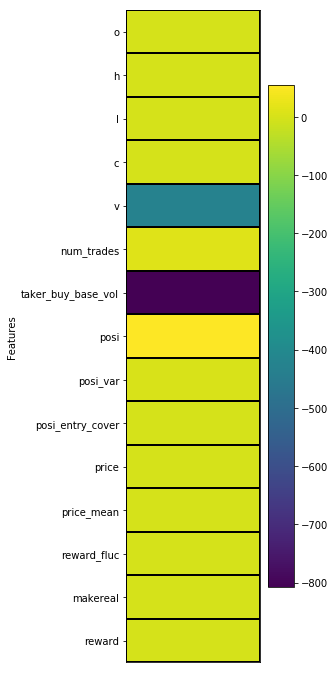

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
ax.pcolormesh(imp_sum, cmap='viridis', edgecolors='black')
ax.set_ylabel('Features')
ax.set_yticks(np.arange(15)+0.5)
ax.set_yticklabels(['o', 'h','l','c','v', 'num_trades', 'taker_buy_base_vol',
                    'posi', 'posi_var', 'posi_entry_cover', 'price', 'price_mean',
                    'reward_fluc', 'makereal', 'reward'][::-1])
ax.set_xticks([])
fig.colorbar(img)
# for i in range(importances.shape[1]):
#     text = ax.text(0.5, i+0.5, '{:f}'.format(imp_sum[i, 0].item()),
#                    ha="center", va="center", color="b",
#                    path_effects=[PathEffects.withStroke(linewidth=5, foreground='w')])

In [28]:
concat = torch.stack(importances_list)
concat.shape

torch.Size([11, 192, 15])

In [29]:
concat_sum = concat.sum(dim= 1)

In [30]:
concat_sum.shape

torch.Size([11, 15])

Text(0.5, 0, 'Actions')

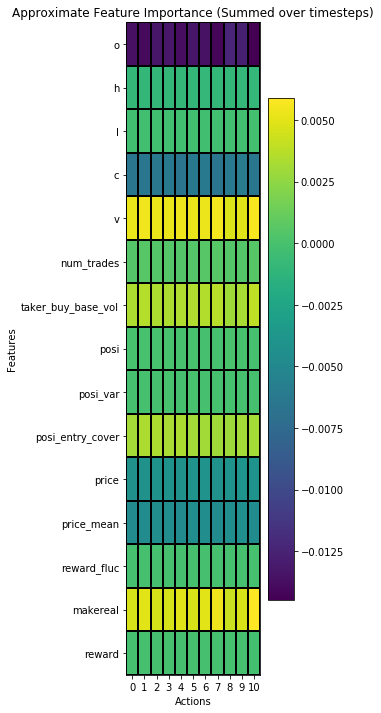

In [32]:
imp_sum = concat_sum.t().flip([0])

fig, ax = plt.subplots(1, 1, figsize=(3, 12))

img = ax.pcolormesh(imp_sum, cmap='viridis', edgecolors='black')
fig.colorbar(img)

ax.set_title('Approximate Feature Importance (Summed over timesteps)')

ax.set_ylabel('Features')
ax.set_yticks(np.arange(importances_list[0].shape[1]) + 0.5)
ax.set_yticklabels(['o', 'h','l','c','v', 'num_trades', 'taker_buy_base_vol',
                    'posi', 'posi_var', 'posi_entry_cover', 'price', 'price_mean',
                    'reward_fluc', 'makereal', 'reward'][::-1])
# plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(list(map(str,range(11))))
ax.set_xlabel('Actions')
# for i in range(importances.shape[1]):
#     text = ax.text(0.5, i+0.5, '{:f}'.format(imp_sum[i, 0].item()),
#                    ha="center", va="center", color="b",
#                    path_effects=[PathEffects.withStroke(linewidth=5, foreground='w')])

---
